# Convolutional Neural Networks로 이미지 분류기 생성

In [1]:
# tensorflow와 tf.keras를 임포트한다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트한다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

%matplotlib inline

1.13.1


## 패션 MNIST 데이터셋 임포트하기

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋을 사용하겠습니다. 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냅니다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

패션 MNIST는 컴퓨터 비전 분야의 "Hello, World" 프로그램격인 고전 [MNIST](http://yann.lecun.com/exdb/mnist/) 데이터셋을 대신해서 자주 사용됩니다. MNIST 데이터셋은 손글씨 숫자(0, 1, 2 등)의 이미지로 이루어져 있습니다. 여기서 사용하려는 옷 이미지와 동일한 포맷입니다.

패션 MNIST는 일반적인 MNIST 보다 조금 더 어려운 문제이고 다양한 예제를 만들기 위해 선택했습니다. 두 데이터셋은 비교적 작기 때문에 알고리즘의 작동 여부를 확인하기 위해 사용되곤 합니다. 코드를 테스트하고 디버깅하는 용도로 좋습니다.

네트워크를 훈련하는데 60,000개의 이미지를 사용합니다. 그다음 네트워크가 얼마나 정확하게 이미지를 분류하는지 10,000개의 이미지로 평가하겠습니다. 패션 MNIST 데이터셋은 텐서플로에서 바로 임포트하여 적재할 수 있습니다:

In [36]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """`path`에서 MNIST 데이터 불러오기"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images.reshape(-1,28,28,1), labels

In [38]:
train_images, train_labels = load_mnist('../data', kind='train')
print(train_images.shape)


(60000, 28, 28, 1)


In [39]:
test_images, test_labels = load_mnist('../data', kind='t10k')
print(test_images.shape)


(10000, 28, 28, 1)


load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환됩니다:

* `train_images`와 `train_labels` 배열은 모델 학습에 사용되는 *훈련 세트*입니다.
* `test_images`와 `test_labels` 배열은 모델 테스트에 사용되는 *테스트 세트*입니다.

이미지는 28x28 크기의 넘파이 배열이고 픽셀 값은 0과 255 사이입니다. *레이블*(label)은 0에서 9까지의 정수 배열입니다. 이 값은 이미지에 있는 옷의 *클래스*(class)를 나타냅니다:

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

각 이미지는 하나의 레이블에 매핑되어 있습니다. 데이터셋에 *클래스 이름*이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장합니다:

In [24]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 데이터 탐색

모델을 훈련하기 전에 데이터셋 구조를 살펴보죠. 다음 코드는 훈련 세트에 60,000개의 이미지가 있다는 것을 보여줍니다. 각 이미지는 28x28 픽셀로 표현됩니다:

In [40]:
train_images.shape

(60000, 28, 28, 1)

비슷하게 훈련 세트에는 60,000개의 레이블이 있습니다:

In [41]:
len(train_labels)

60000

각 레이블은 0과 9사이의 정수입니다:

In [42]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

테스트 세트에는 10,000개의 이미지가 있습니다. 이 이미지도 28x28 픽셀로 표현됩니다:

In [43]:
test_images.shape

(10000, 28, 28, 1)

테스트 세트는 10,000개의 이미지에 대한 레이블을 가지고 있습니다:

In [44]:
len(test_labels)

10000

## 데이터 전처리

네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있습니다:

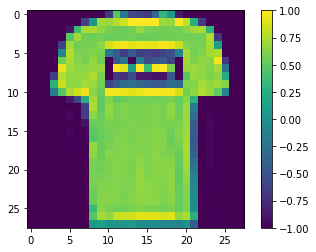

In [46]:
plt.figure()
plt.imshow(train_images[1].reshape(28,28))
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정하겠습니다. 이렇게 하려면 255로 나누어야 합니다. *훈련 세트*와 *테스트 세트*를 동일한 방식으로 전처리하는 것이 중요합니다:

In [47]:
train_images = train_images / 255.0

test_images = test_images / 255.0

*훈련 세트*에서 처음 25개 이미지와 그 아래 클래스 이름을 출력해 보죠. 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마칩니다.

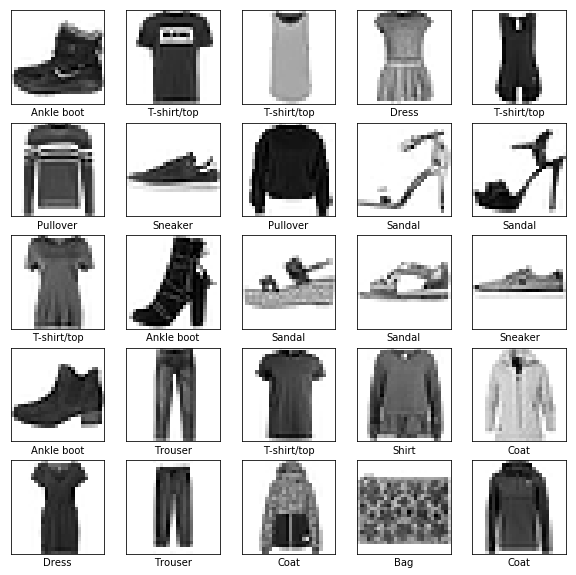

In [48]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 모델 구성

신경망 모델을 만들려면 모델의 층을 구성한 다음 모델을 컴파일합니다.

### 층 설정

CNN모형의 layer를 구성한다.
* **"convolutions"** `tf.keras.layers.Conv2D` 와 `MaxPooling2D`

* **output** `tf.keras.layers.Dense` - 10-node의 output *softmax* layer로 클래스의 확률을 출력한다. 


In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28,28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

### 모델 컴파일

모델을 훈련하기 전에 필요한 몇 가지 설정이 모델 *컴파일* 단계에서 추가됩니다:

* *손실 함수*(Loss function)-훈련 하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다.
* *옵티마이저*(Optimizer)-데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.
* *지표*(Metrics)-훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 *정확도*를 사용합니다.

In [50]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 모델 훈련

신경망 모델을 훈련하는 단계는 다음과 같습니다:

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 `train_images`와 `train_labels` 배열입니다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 `test_images` 배열입니다. 이 예측이 `test_labels` 배열의 레이블과 맞는지 확인합니다.

훈련을 시작하기 위해 `model.fit` 메서드를 호출하면 모델이 훈련 데이터를 학습합니다:

In [51]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 128s 2ms/sample - loss: 0.7376 - acc: 0.7276s - loss: 0.7380 - acc: 0.
Epoch 2/5
60000/60000 [==============================] - 139s 2ms/sample - loss: 0.4974 - acc: 0.8189
Epoch 3/5
60000/60000 [==============================] - 148s 2ms/sample - loss: 0.4242 - acc: 0.8473
Epoch 4/5
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.3868 - acc: 0.8599
Epoch 5/5
60000/60000 [==============================] - 151s 3ms/sample - loss: 0.3610 - acc: 0.8685


모델이 훈련되면서 손실과 정확도 지표가 출력됩니다. 

## 정확도 평가

그다음 테스트 세트에서 모델의 성능을 비교합니다:

In [52]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('테스트 정확도:', test_acc)

10000/10000 [==============================] - 5s 509us/sample - loss: 0.3644 - acc: 0.8712
테스트 정확도: 0.8712


## 예측 만들기

훈련된 모델을 사용하여 이미지에 대한 예측을 만들 수 있습니다.

In [53]:
predictions = model.predict(test_images)

여기서는 테스트 세트에 있는 각 이미지의 레이블을 예측했습니다. 첫 번째 예측을 확인해 보죠:

In [54]:
predictions[0]

array([5.9138806e-06, 1.4353820e-07, 5.4444913e-06, 2.4132473e-06,
       1.8634638e-06, 1.5815474e-02, 6.7721876e-06, 1.3999932e-01,
       3.0175652e-03, 8.4114510e-01], dtype=float32)

이 예측은 10개의 숫자 배열로 나타납니다. 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냅니다. 가장 높은 신뢰도를 가진 레이블을 찾아보죠:

In [55]:
np.argmax(predictions[0])

9

모델은 이 이미지가 앵클 부츠(`class_name[9]`)라고 가장 확신하고 있습니다. 이 값이 맞는지 테스트 레이블을 확인해 보죠:

In [56]:
test_labels[0]

9

10개의 신뢰도를 모두 그래프로 표현해 보겠습니다:

In [57]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인해 보겠습니다.

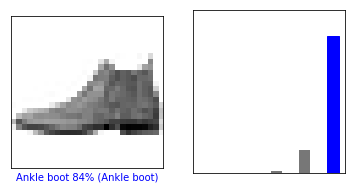

In [58]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

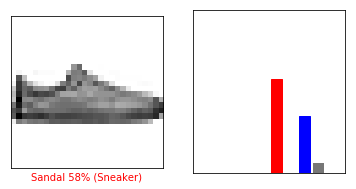

In [59]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

몇 개의 이미지의 예측을 출력해 보죠. 올바르게 예측된 레이블은 파란색이고 잘못 예측된 레이블은 빨강색입니다. 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)입니다. 신뢰도 점수가 높을 때도 잘못 예측할 수 있습니다.

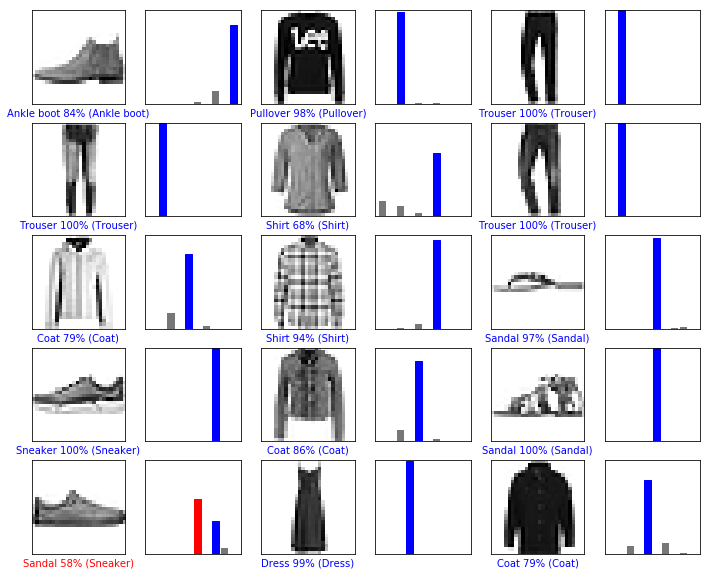

In [60]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
# 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.show()

마지막으로 훈련된 모델을 사용하여 한 이미지에 대한 예측을 만듭니다.

In [61]:
# 테스트 세트에서 이미지 하나를 선택합니다
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras` 모델은 한 번에 샘플의 묶음 또는 *배치*(batch)로 예측을 만드는데 최적화되어 있습니다. 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 합니다:

In [62]:
# 이미지 하나만 사용할 때도 배치에 추가합니다
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28, 1)


이제 이 이미지의 예측을 만듭니다:

In [63]:
predictions_single = model.predict(img)

print(predictions_single)

[[5.9138852e-06 1.4353844e-07 5.4445059e-06 2.4132539e-06 1.8634686e-06
  1.5815493e-02 6.7721862e-06 1.3999943e-01 3.0175673e-03 8.4114492e-01]]


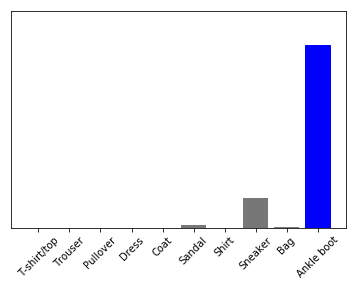

In [64]:
plot_value_array(0, predictions_single, test_labels)
plt.xticks(range(10), class_names, rotation=45)
plt.show()

`model.predict`는 2차원 넘파이 배열을 반환하므로 첫 번째 이미지의 예측을 선택합니다:

In [65]:
prediction_result = np.argmax(predictions_single[0])
print(prediction_result)

9


이전과 마찬가지로 모델의 예측은 레이블 9입니다.

# Exercises

다음과 같이 설정값을 바꾸었을때 정확도가 어떻게 달라지는지 확인해 보시오:
*   training epoch의 횟수를 1로 설정했을때 정확도가 어떻게 달라지는가?
*   첫번째 Dense layer의 hidden unit의 수를 10으로 변경했을때 정확도는 어떻게 달라지는가?
*   첫번째 Dense layer의 hidden unit의 수를 512로 변경했을때 정확도는 어떻게 달라지는가?
*   마지막 dense layer 전에 Dense layer를 하나 더 추가해 보시오. 이때 정확도는 어떻게 달라지는가?
*   normalize를 수행하지 않는다면 결과가 어떻게 되는지 확인해 보시오.

